# Analytical solution of diffusion equation

$N$ particles are located at $x = 0$ at $t = 0$, and can diffuse in a medium with constant diffusion coefficient $D$, 
then the dynamics of particle concentration $c(x, t)$ is given by diffusion equation

$$ \partial_{t} c(x, t) = D \partial_{x}^{2} c(x, t) \quad. $$

With initial conditions $ c(x, t)|_{t = 0} = N \delta(x)$.

To solve the diffusion equation, let's apply the Fourier transform to both sides of the equation, the Fourier transform of $ c(x, t) $ is defined as $ \hat{c}(\xi, t) = \int_{-\infty}^{\infty} c(x, t) e^{-i \xi x} \, dx $,

$$ \partial_{t} \hat{c}(\xi, t) = -\xi^2 D \hat{c}(\xi, t)  \quad. $$

This is an ordinary differential equation for $ \hat{c}(\xi, t) $ and its solution is

$$ \hat{c}(\xi, t) = \hat{c}(\xi, 0) e^{-D \xi^2 t}  \quad $$

or given the initial condition $ c(x, t)|_{t = 0} = N \delta(x) $

$$ \hat{c}(\xi, t) = N e^{-D \xi^2 t}  \quad. $$

To find the solution in real space, let's apply the inverse Fourier transform to the last equation:

$$ c(x, t) = \mathcal{F}_{x}^{-1}[ \hat{c}(\xi, t)](x) = \frac{N}{2\pi} \int_{-\infty}^{\infty} e^{-D \xi^2 t} e^{i \xi x} \, d\xi  \quad. $$

Appling the known Gauss integral $ \int_{-\infty}^{+\infty} e^{-x^{2}} d x = \sqrt{\pi} $ and $i \xi x + D \xi^{2} t = (\sqrt{Dt} \xi + \frac{x i}{2 \sqrt{D t}})^{2} + \frac{x^{2}}{4 D t}$, we obtain the final analytical solution to the diffusion equation with the initial condition $ N \delta(x) $:

$$ c(x, t) = \frac{N}{\sqrt{4 \pi D t}} e^{-\frac{x^2}{4Dt}}   \quad.  $$

*This solution can be found in multiple textbooks, for example, "Introduction to Partial Differential Equations" by Peter J. Olver*.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from theoretical_biophysics.plot_style import *

In [2]:
def analytical_solution(x, t, D, N):
    """
    Analytical solution of diffusion equation \partial_{t} c(x, t) = D \partial_{x}^{2} c(x, t).
    Parameters:
    x  : np.array
    t  : float   - time point
    D  : float   - diffusion coefficient
    N  : int     - number of particles
    Returns:
    np.array
    """
    return (N / np.sqrt(4 * np.pi * D * t)) * np.exp(-x**2 / (4 * D * t))

In [3]:
N = 1e2  # Number of particles
D = 1.0  # Diffusion coefficient

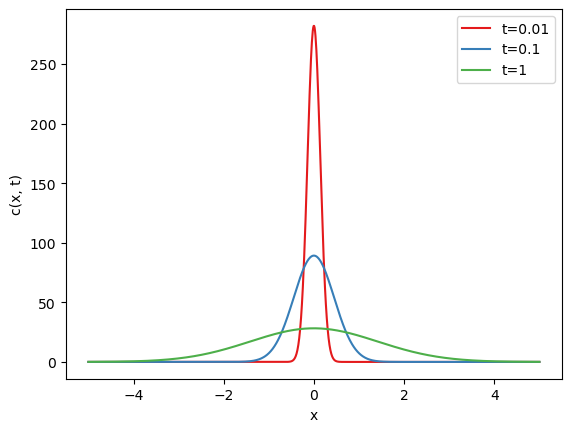

In [20]:
ax = plt.subplot()
colors = plt.cm.Set1.colors

x_to_plot = np.linspace(-5, 5, 1000)

# plot a few time point
i = 0
for t in [0.01, 0.1, 1]:
    ax.plot(x_to_plot, analytical_solution(x_to_plot, t, D, N), label=f't={t}', color=colors[i])
    i+=1
    
plt.xlabel('x')
plt.ylabel('c(x, t)')
plt.legend()
plt.show()

# Numerical solution of diffusion equation

**Euler Scheme**

The same solution for the diffusion equation can also be found numerically using the Euler scheme ([Wikipedia](https://en.wikipedia.org/wiki/Euler_method)). The Euler scheme is a simple numerical method for solving differential equations by approximating the solution at small time steps. This method iteratively updates the concentration values based on the current values and the discretized second spatial derivative.

For the diffusion equation:

$$ \partial_{t} c(x, t) = D \partial_{x}^{2} c(x, t) \quad $$

the Euler scheme approximates the solution as:

$$ c_i^{n+1} = c_i^n + \Delta t \cdot D \frac{c_{i+1}^n - 2c_i^n + c_{i-1}^n}{\Delta x^2} \quad, $$

where:
- $ c_i^n $ is the concentration at position $ x_i $ and time $ t_n $.
- $ \Delta t $ is the time step size.
- $ \Delta x $ is the spatial step size.

In [5]:
# parameters for Euler scheme

tmax = 1    # time till what to calculate solution
Lmax = 1e2  # system size, boundaries are far away ~ infinity

dt   = 1e-3 # time step
dx   = 0.5*1e-1 # spatial step

In [6]:
# arrays for space and time coordinates

x   = np.linspace(-Lmax, Lmax, 2*int(Lmax/dx)+1)
ndx = len(x)

t   = np.linspace(0, tmax, int(tmax/dt)+1)
ndt = len(t)

**Stability of numerical scheme**

To ensure numerical stability, the Euler scheme must satisfy the Courant–Friedrichs–Lewy (CFL) condition:

$$ D \frac{\Delta t}{\Delta x^2} \leq \frac{1}{2} \quad. $$

This condition ensures that the time step is sufficiently small relative to the spatial step size and the diffusion coefficient. 

In [7]:
if D*dt/dx**2 < 0.5:
    print(f'the Courant condition is fullfilled, D*dt/dx**2 = {np.round(D*dt/dx**2, 2)}')
else:
    print(f'the Courant condition is NOT fullfilled, please, revise parameters for Euler scheme')
    print(f'D*dt/dx**2 = {np.round(D*dt/dx**2, 2)}')

the Courant condition is fullfilled, D*dt/dx**2 = 0.4


In [8]:
def numerical_laplacian(c, dx):
    """
    Numerical lapplacian for the concentration array.
    Parameters:
    c  : np.array - concentration array
    dx : float   - spatial discretization size
    Returns:
    np.array
    """
    c_iminus  = np.roll(c, 1)
    c_iplus   = np.roll(c, -1)
    laplacian = (c_iplus - 2*c + c_iminus)/dx**2
    return laplacian

In [9]:
# list for the spatial profiles of concentration c as function of time
ct = []

# inital conditions: concentration N/dx at x = 0
c0 = np.zeros_like(x)
c0[np.where(x == 0)] = N/dx
ct.append(c0)

In [10]:
from tqdm import tqdm # library to visualize the progress status of a python loop

# loop through time 
for n in tqdm( range(1, ndt) ):
    c_n = ct[-1]
    c_nplus = c_n + D * numerical_laplacian(c_n, dx) * dt
    ct.append(c_nplus)

100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 11136.35it/s]


for latex figure: width=90mm, height=55.62mm


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


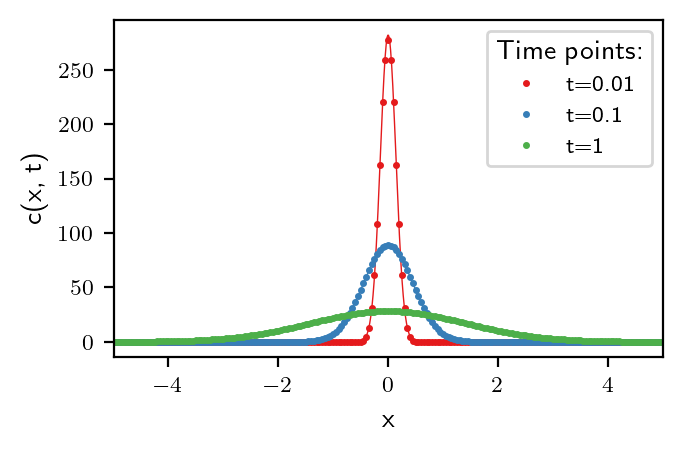

In [29]:
apply_my_plot_style_globally()
set_one_column_figure()

ax = plt.subplot()
x_to_plot = np.linspace(-5, 5, 1000)

colors = plt.cm.Set1.colors

# plot a few time point
i = 0
for t in [0.01, 0.1, 1]:
    ax.plot(x_to_plot, analytical_solution(x_to_plot, t, D, N), color=colors[i])
    ax.plot(x, ct[int(t/dt)], '.',color=colors[i], label=f't={t}')
    i+=1
    
plt.xlabel('x')
plt.ylabel('c(x, t)')
plt.xlim(-5, 5)
plt.legend(title='Time points:')
plt.savefig('analytical_and_numerical_sol_comparison.eps', bbox_inches='tight', format='eps')
plt.show()
plt.rcParams.update(rcParamsDefault)